### ESN application: Classification and layer-wise relevance propagation (LRP) with synthetic data

In *ESN_exp09* we have done classification of sst anomaly fields with ESN models. Afterwards we applied LRP and found **leakrate $\alpha$** to serve as a **memory parameter**.

In this experiment we want to further **investigate the fading memory effect** on synthetic data. The idea is to create samples with identical right-hand side, that can only be discriminated by their left half. We then feed these samples **col-wise** into a base ESN model, sweeping from left to right and vice versa, with increasing leakrate.

### Tech preamble

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.special import softmax, expit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Work with my own library of useful ESN functions
from ESN_functions_v05 import * 

### Create synthetic data

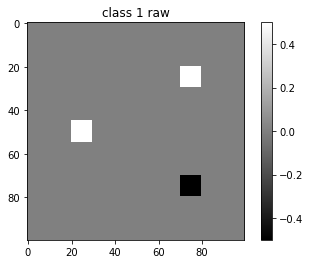

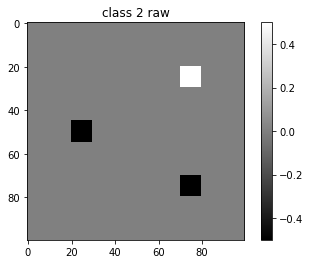

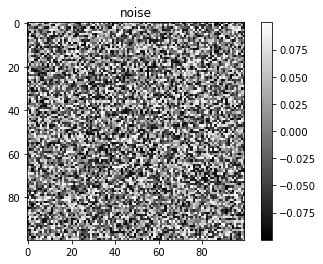

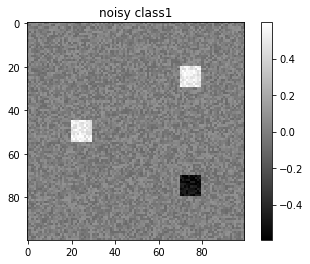

train_input_swap:  (400, 100, 100)
val_input_swap:  (100, 100, 100)
train_target:  (400, 1)
val_target:  (100, 1)


In [19]:
# Start with sample of size 100 x 100 pixels, initialized as zeros:
temp_sample = np.zeros((100,100))

# Now add two squares in the right half of the sample:
temp_sample[20:30,70:80] = 0.5
temp_sample[70:80,70:80] = -0.5

## Now create raw sample for class 1 and 2:

# class 1: additional positive square, centered at the left-hand side
class1_raw = np.copy(temp_sample)
class1_raw[45:55,20:30] = 0.5

# class 2: additional negative square, centered at the left-hand side
class2_raw = np.copy(temp_sample)
class2_raw[45:55,20:30] = -0.5

# Plot raw samples for class 1 and 2:
plt.imshow(class1_raw, cmap='gray', interpolation='nearest')
plt.title("class 1 raw")
plt.colorbar()
plt.show()

plt.imshow(class2_raw, cmap='gray', interpolation='nearest')
plt.title("class 2 raw")
plt.colorbar()
plt.show()

# Now create some noise:
noise = np.random.uniform(low=-0.1, high=0.1, size=(100,100))

# Plot example noise:
plt.imshow(noise, cmap='gray', interpolation='nearest')
plt.title("noise")
plt.colorbar()
plt.show()

# Add noise to class samples:
class1_noisy = class1_raw + noise

# Plot noisy class1 sample:
plt.imshow(class1_noisy, cmap='gray', interpolation='nearest')
plt.title("noisy class1")
plt.colorbar()
plt.show()

## Create some more noisy samples:

# specify number of samples per class:
n_samples = 250

# Choose ratio of train to validation samples:
train_val_split = 0.8

# Initialize storage for all samples:
samples = np.zeros((2 * n_samples, 100, 100))

# Loop over desired nomber of samples:
for i in range(n_samples):
    
    # Now create some noise:
    noise = np.random.uniform(low=-0.1, high=0.1, size=(100,100))
    
    # Store noisy class 1 sample:
    samples[i] = class1_raw + noise

    # Store noisy class 2 sample:
    samples[i + n_samples] = class2_raw + noise
    
# Split samples into train and validation data:
n_train = int(n_samples * train_val_split)
train_input = np.concatenate([samples[:n_train], samples[n_samples:n_samples+n_train]], axis=0)
val_input = np.concatenate([samples[n_train:n_samples], samples[n_samples+n_train:]], axis=0)

# Need to swap samples' axes to feed samples col-wise into model:
train_input_swap = np.swapaxes(train_input, 1, 2)
val_input_swap = np.swapaxes(val_input, 1, 2)

# Create targets: 1 for class1 and -1 for class2
train_target = np.concatenate([np.ones((n_train,1)), -np.ones((n_train,1))])
val_target = np.concatenate([np.ones((n_samples-n_train,1)), -np.ones((n_samples-n_train,1))])
               

# Check dimensions:
print("train_input_swap: ", train_input_swap.shape)
print("val_input_swap: ", val_input_swap.shape)
print("train_target: ", train_target.shape)
print("val_target: ", val_target.shape)

### Classification with baseESN (column-wise) on single binary target (+/- 1)


#### Base parameter setup

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.005
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on synthetic noisy **swapped input samples** - by definition **scaled to [-1,1]**, together with **tanh** activation. Multiplication with $\alpha$ is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*).

In [85]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 1 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events on one-hot targets.

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100, 100)]        0         
_________________________________________________________________
esn_15 (ESN)                 ((None, 100, 300), (None, 120600    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 120,901
Trainable params: 120,901
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100, 100)]        0         
_________________________________________________________________
esn_15 (ESN)                 ((None, 100, 300), (None, 120600    
Total params: 120,600
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (400, 100, 100)
shape of model output X_T (samples, n_res):  (400, 300)

Final reservoir states in augmented notation, shape:  (400, 301)

train_target shape (samples, output features):  (400, 1)

W_out shape:  (300, 1)
b_out shape:  (1,)

output feature  0 , trained b_out:  [53.91262388]


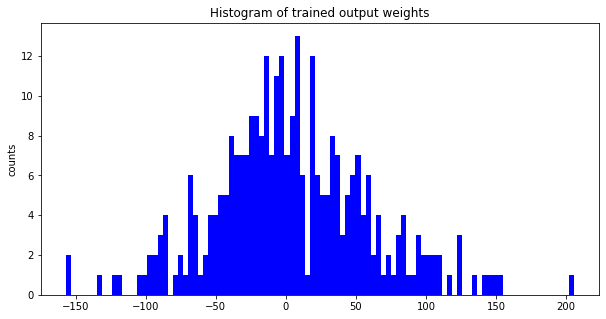


shape of val input (samples, timesteps, features):  (100, 100, 100)
shape of train input (samples, timesteps, features):  (400, 100, 100)

shape of model predictions on validation input (samples, 1):  (100, 1)
shape of val targets (samples, 1):  (100, 1)

train_mae:  0.0021
val_mae:  0.4226

train_mse:  0.0
val_mse:  0.2841


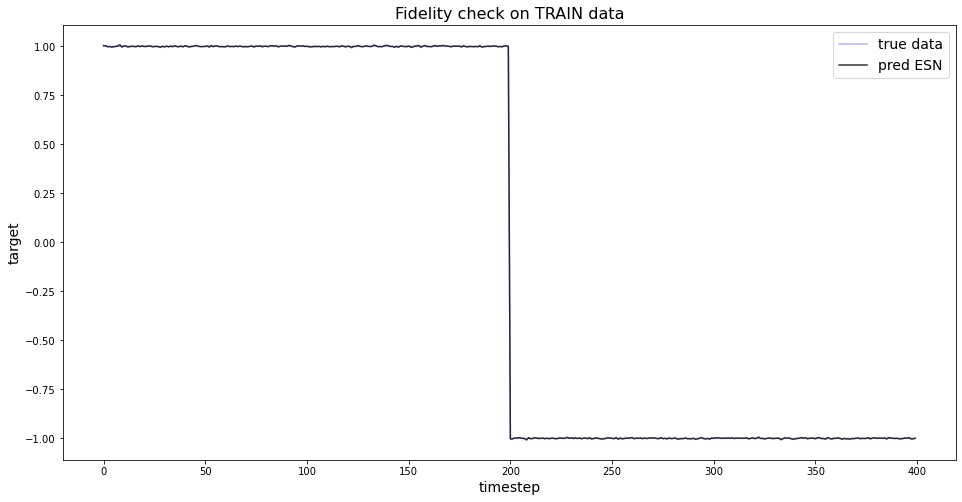

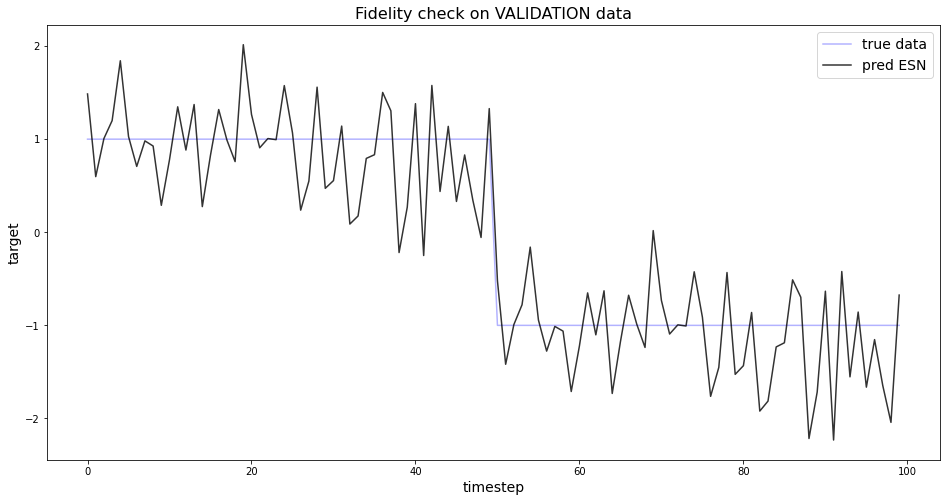

In [86]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_swap, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_swap, val_input_swap,
                                                                       train_target, val_target,
                                                                       verbose=verbose)



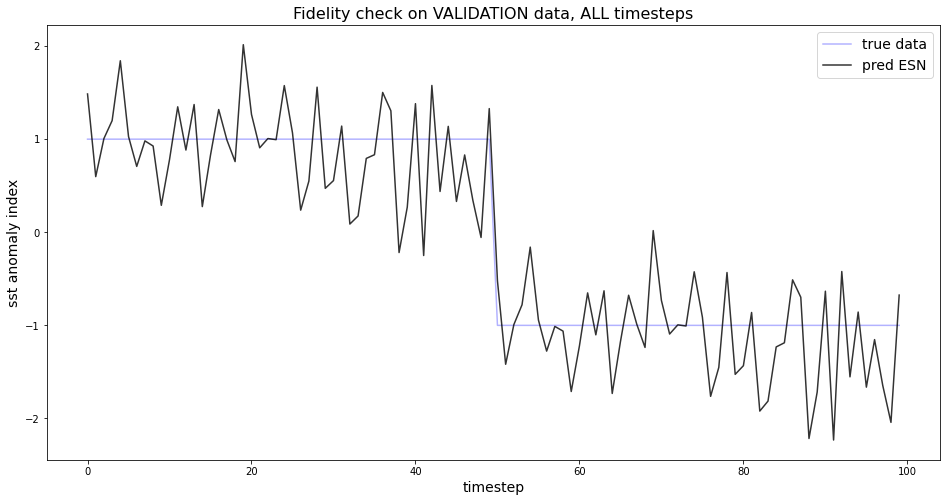


Validation accuracy:
El Nino:  0.94
La Nina:  0.98

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [87]:
# Convert to binary prediction (+1 / -1):
train_pred_bin = (train_pred > 0).astype(int) - (train_pred < 0).astype(int)
val_pred_bin = (val_pred > 0).astype(int) - (val_pred < 0).astype(int)

if verbose:   

    # Fidelity check: Plot val_pred vs. val_targets, ALL timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target[:,0])),val_target[:,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:,0])),val_pred[:,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('Fidelity check on VALIDATION data, ALL timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    

## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target[:,0]) & (val_target[:,0] == 1)) / sum(val_target[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,0] == val_target[:,0]) & (val_target[:,0] == -1)) / sum(val_target[:,0] == -1)

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target[:,0]) & (train_target[:,0] == 1)) / sum(train_target[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,0] == train_target[:,0]) & (train_target[:,0] == -1)) / sum(train_target[:,0] == -1)


if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

### Sweep from right to left

Now still feed samples col-wise into base ESN model, but flip input columns. This is equivalent to sweeping from right to left, instead of from left to right, as above.

In [71]:
# Flip swapped inputs along time-axis:
train_input_swap_flip = np.flip(train_input_swap, axis=1)
val_input_swap_flip = np.flip(val_input_swap, axis=1)

In [72]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap_flip.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.5 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap_flip.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 1 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events on one-hot targets.

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100, 100)]        0         
_________________________________________________________________
esn_14 (ESN)                 ((None, 100, 300), (None, 120600    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 120,901
Trainable params: 120,901
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100, 100)]        0         
_________________________________________________________________
esn_14 (ESN)                 ((None, 100, 300), (None, 120600    
Total params: 120,600
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (400, 100, 100)
shape of model output X_T (samples, n_res):  (400, 300)

Final reservoir states in augmented notation, shape:  (400, 301)

train_target shape (samples, output features):  (400, 1)

W_out shape:  (300, 1)
b_out shape:  (1,)

output feature  0 , trained b_out:  [13.87066807]


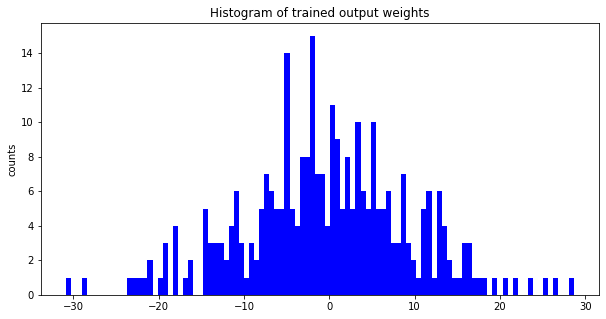


shape of val input (samples, timesteps, features):  (100, 100, 100)
shape of train input (samples, timesteps, features):  (400, 100, 100)

shape of model predictions on validation input (samples, 1):  (100, 1)
shape of val targets (samples, 1):  (100, 1)

train_mae:  0.003
val_mae:  0.8178

train_mse:  0.0
val_mse:  1.0257


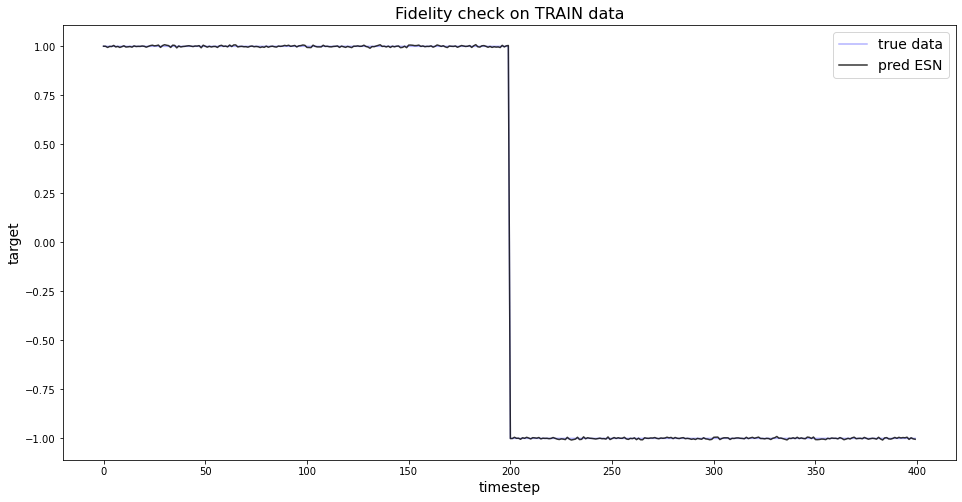

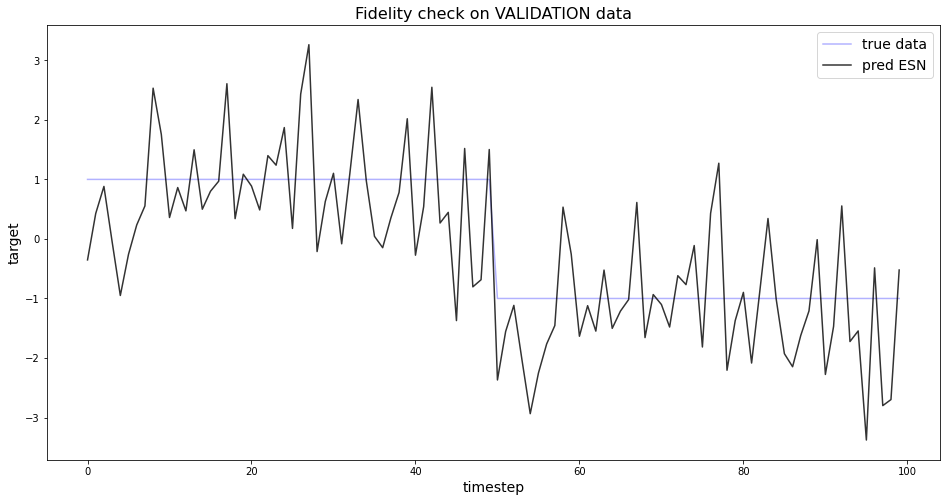

In [73]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_swap_flip, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_swap_flip,
                                                                       val_input_swap_flip,
                                                                       train_target, val_target,
                                                                       verbose=verbose)




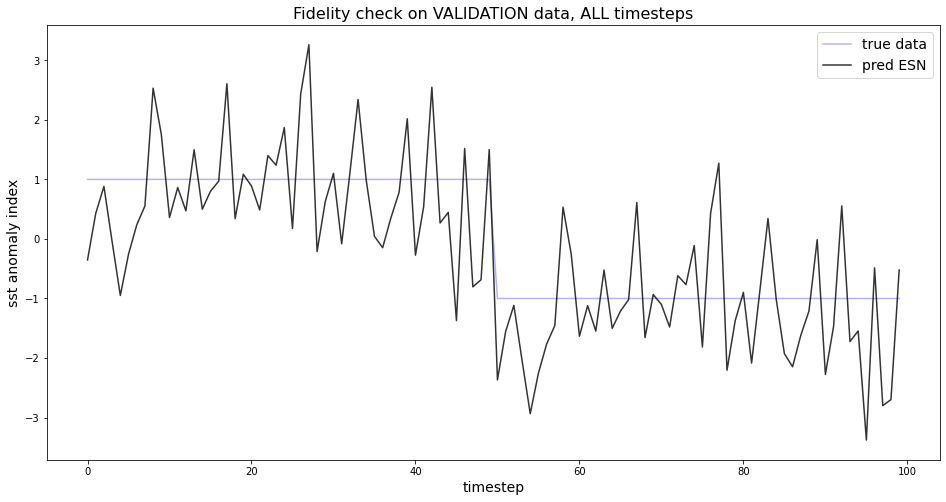


Validation accuracy:
El Nino:  0.78
La Nina:  0.88

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [74]:
# Convert to binary prediction (+1 / -1):
train_pred_bin = (train_pred > 0).astype(int) - (train_pred < 0).astype(int)
val_pred_bin = (val_pred > 0).astype(int) - (val_pred < 0).astype(int)

if verbose:   

    # Fidelity check: Plot val_pred vs. val_targets, ALL timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target[:,0])),val_target[:,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:,0])),val_pred[:,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('Fidelity check on VALIDATION data, ALL timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    

## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target[:,0]) & (val_target[:,0] == 1)) / sum(val_target[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,0] == val_target[:,0]) & (val_target[:,0] == -1)) / sum(val_target[:,0] == -1)

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target[:,0]) & (train_target[:,0] == 1)) / sum(train_target[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,0] == train_target[:,0]) & (train_target[:,0] == -1)) / sum(train_target[:,0] == -1)


if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

### LRP on col-wise baseESN, sweeped from left to right

In [66]:
### Pick out ONE  sample to be analysed:

## Class 1: E.g. take the very first sample
sample = val_input_swap[:1,:,:]

## Class 2: E.g. take the very last sample
#sample = val_input_swap[-1:,:,:]

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample: ", np.round(pred[0,0],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 100, 100)
number of timesteps:  100
number of input features in_feat:  100
number of res. units n_res:  300
leak rate alpha:  0.3
model prediction on sample:  -85.305

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (100, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 1)
output biases b_out (output features):  (1,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1111/2775359836.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Tensor shapes:
input tensor U (timesteps, input features):  (100, 100)
all res. states X (timesteps, res. units):  (100, 300)
activations ACT (timesteps, res. units):  (100, 300)


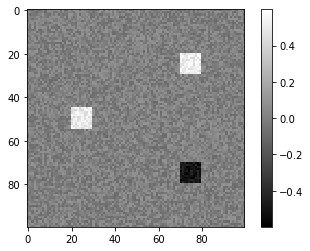

In [59]:
# Plot sample in reduced size:
plt.imshow(np.swapaxes(sample[0,:,:], 0,1), cmap='gray', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [69]:
### LRP on baseESN (col-wise): Only take positive contributions of pre-potential into account.
### EL NINO

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_1pos = np.swapaxes(R_all, 0, 1)

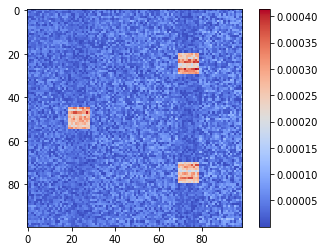

In [62]:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.01
# Relevance heatmap for single sample from class1, scaled to [-1,1]
# Single binary target (+1 / -1)
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

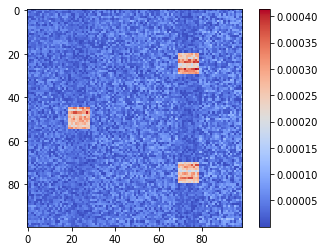

In [61]:
## LEFT to RIGHT sweep:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.01
# Relevance heatmap for single sample from class1, scaled to [-1,1]
# Single binary target (+1 / -1)
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

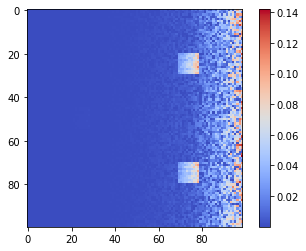

In [70]:
## LEFT to RIGHT sweep:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.3
# Relevance heatmap for single sample from class1, scaled to [-1,1]
# Single binary target (+1 / -1)
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

### LRP on col-wise baseESN, sweeped from right to left

In [75]:
### Pick out ONE  sample to be analysed:

## Class 1: E.g. take the very first sample
sample = val_input_swap_flip[:1,:,:]

## Class 2: E.g. take the very last sample
#sample = val_input_swap_flip[-1:,:,:]

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample: ", np.round(pred[0,0],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 100, 100)
number of timesteps:  100
number of input features in_feat:  100
number of res. units n_res:  300
leak rate alpha:  0.5
model prediction on sample:  -0.352

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (100, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 1)
output biases b_out (output features):  (1,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1111/2708067047.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Tensor shapes:
input tensor U (timesteps, input features):  (100, 100)
all res. states X (timesteps, res. units):  (100, 300)
activations ACT (timesteps, res. units):  (100, 300)


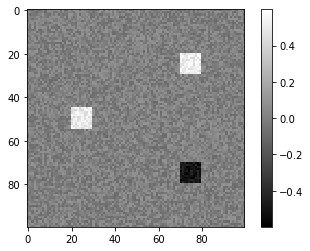

In [78]:
# Plot sample in reduced size:
plt.imshow(np.flip(np.swapaxes(sample[0,:,:], 0,1), axis=1), cmap='gray', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [83]:
### LRP on baseESN (col-wise): Only take positive contributions of pre-potential into account.
### EL NINO

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped and flipped sample (lat <-> lon), reverse swapping and flip along time-axis:
R_all_1pos = np.flip(np.swapaxes(R_all, 0, 1), axis=1)

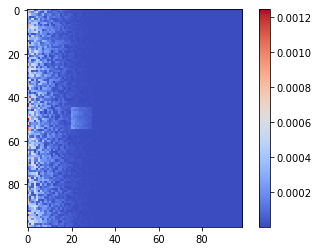

In [84]:
## RIGHT to LEFT sweep:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.5
# Relevance heatmap for single sample from class1, scaled to [-1,1]
# Single binary target (+1 / -1)
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [175]:
### LRP for baseESN (col-wise): LA NINA
### Since we work with single continuous target, take inverse prediction (= positive) as final relevance.
### Then only take negative contributions of pre-potential into account.

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0])) * -pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0])) * -pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_2pos = np.swapaxes(R_all, 0, 1)

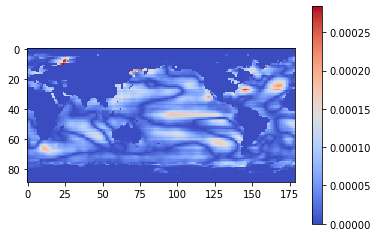

In [176]:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.005
# Relevance heatmap for single La Nina sample, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

### baseESN (column-wise): Get mean relevance maps for all samples of class1 and class2, respectively

In [88]:
### LRP with baseESN on ALL class1 / class2 samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input_swap[(train_target==1)[:,0]]
samples_LaNina = train_input_swap[(train_target==-1)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,0]
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_ElNino)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nino = np.swapaxes(R_all_mean, 0, 1)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1111/682435555.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  200
sample:  2  from  200
sample:  3  from  200
sample:  4  from  200
sample:  5  from  200
sample:  6  from  200
sample:  7  from  200
sample:  8  from  200
sample:  9  from  200
sample:  10  from  200
sample:  11  from  200
sample:  12  from  200
sample:  13  from  200
sample:  14  from  200
sample:  15  from  200
sample:  16  from  200
sample:  17  from  200
sample:  18  from  200
sample:  19  from  200
sample:  20  from  200
sample:  21  from  200
sample:  22  from  200
sample:  23  from  200
sample:  24  from  200
sample:  25  from  200
sample:  26  from  200
sample:  27  from  200
sample:  28  from  200
sample:  29  from  200
sample:  30  from  200
sample:  31  from  200
sample:  32  from  200
sample:  33  from  200
sample:  34  from  200
sample:  35  from  200
sample:  36  from  200
sample:  37  from  200
sample:  38  from  200
sample:  39  from  200
sample:  40  from  200
sample:  41  from  200
sample:  42  from  200
sample:  43  from  200
sample:  44  from  2

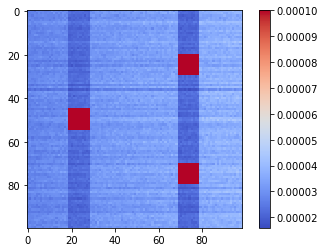

In [89]:
# baseESN, feed inputs col-wise into model, tanh activation
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest', vmax=0.0001)
plt.colorbar()
plt.show()

In [188]:
## Initialize storage for mean relevance over all LaNina samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_LaNina)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_LaNina))
    
    # Get current sample:
    sample = samples_LaNina[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,0]
    #print(pred)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0])) * -pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])<0) * np.multiply(ACT[T,:],W_out[:,0])) * -pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)<0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)<0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_LaNina)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nina = np.swapaxes(R_all_mean, 0, 1)

sample:  1  from  636
sample:  2  from  636
sample:  3  from  636
sample:  4  from  636
sample:  5  from  636
sample:  6  from  636
sample:  7  from  636
sample:  8  from  636
sample:  9  from  636
sample:  10  from  636
sample:  11  from  636
sample:  12  from  636
sample:  13  from  636
sample:  14  from  636
sample:  15  from  636
sample:  16  from  636
sample:  17  from  636
sample:  18  from  636
sample:  19  from  636
sample:  20  from  636
sample:  21  from  636
sample:  22  from  636
sample:  23  from  636
sample:  24  from  636
sample:  25  from  636
sample:  26  from  636
sample:  27  from  636
sample:  28  from  636
sample:  29  from  636
sample:  30  from  636
sample:  31  from  636
sample:  32  from  636
sample:  33  from  636
sample:  34  from  636
sample:  35  from  636
sample:  36  from  636
sample:  37  from  636
sample:  38  from  636
sample:  39  from  636
sample:  40  from  636
sample:  41  from  636
sample:  42  from  636
sample:  43  from  636
sample:  44  from  6

sample:  347  from  636
sample:  348  from  636
sample:  349  from  636
sample:  350  from  636
sample:  351  from  636
sample:  352  from  636
sample:  353  from  636
sample:  354  from  636
sample:  355  from  636
sample:  356  from  636
sample:  357  from  636
sample:  358  from  636
sample:  359  from  636
sample:  360  from  636
sample:  361  from  636
sample:  362  from  636
sample:  363  from  636
sample:  364  from  636
sample:  365  from  636
sample:  366  from  636
sample:  367  from  636
sample:  368  from  636
sample:  369  from  636
sample:  370  from  636
sample:  371  from  636
sample:  372  from  636
sample:  373  from  636
sample:  374  from  636
sample:  375  from  636
sample:  376  from  636
sample:  377  from  636
sample:  378  from  636
sample:  379  from  636
sample:  380  from  636
sample:  381  from  636
sample:  382  from  636
sample:  383  from  636
sample:  384  from  636
sample:  385  from  636
sample:  386  from  636
sample:  387  from  636
sample:  388  fr

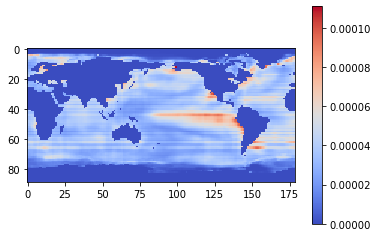

In [189]:
# baseESN, feed inputs col-wise into model, tanh activation
# Mean relevance heatmap La Nina, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.
plt.imshow(R_all_mean_nina, cmap='coolwarm', interpolation='nearest')#, vmax=0.0001)
plt.colorbar()
plt.show()

### Investigate robustness of col-wise base ESN on permuting inputs

sst anomaly is found to have a strong **zonal** character. Feeding inputs column-wise into the model, we support this zonal structure, because each latitude is fed into the model as one long timeseries of 180 steps (= longitude).

We now want to investigate, if our approach is robust against permutation of input gridpoints: For each row we apply some random (but reversible!) permutation of gridpoints.

Then check accuracy and restore (reverse permutation!) relevance map: Does the model still find Nino region to be most relevant?

**Note:** For the above coupled ESN approach, we expect it to be robust against such permutation, since we couple each gridpoint to exactly one reservoir unit and reservoir units are initialized randomly. Permutation should have no effect.

In [9]:
# Get random permutation of number of timesteps (here longitude dimension):
rand_perm = np.random.permutation(train_input_swap.shape[1])
rand_perm

array([122, 176,  54,  26, 110,  79,  78,  25, 116,  72,  67, 128, 171,
       152, 112, 153,  57,  48,  35, 137,  39,   7, 103,  70,  74, 124,
        71,   8,  93,  75,  99, 139,   4, 168,  34,  17, 136, 133, 166,
        29,  92, 149,  61,  16,  41, 178,  52, 155, 106,  31, 118,  24,
        43, 111,   1,   3,  66,  15,  53, 175,  64, 114,  59,  22,   5,
        30,  60, 140,  51,  85,  33,  89,  49,  86, 121, 135, 125, 100,
       107,  76,  84,  36, 119,  96, 120, 108,  90, 147, 144,  73,  98,
       145, 163,  68, 158, 159, 102, 173,  14, 148, 172, 156,  65, 130,
       160,  12,  91,  13,   0, 151,  40, 146, 132,  18, 104,  44,  23,
       115,  81, 109, 177,  45, 157,  80,  10,  94,  50,  21,  87, 170,
         6,  88, 129,  28, 127,  20,  19,  69,  11,  82, 150,  62, 134,
       143, 167, 169,  47,  77, 162, 138,   2,  37,  58, 142,  46,  32,
       105,  38, 117,  83, 113,  42, 165,   9, 164, 141, 126, 174, 131,
        97, 161, 123,  56,  27,  95, 154, 101,  63,  55, 179])

In [49]:
## Now apply this permutation to validation and train inputs:

# Initialize storage (samples, timesteps, features):
val_input_swap_perm = np.zeros(val_input_swap.shape)
train_input_swap_perm = np.zeros(train_input_swap.shape)

## Validation inputs: 

# Loop over number of samples:
for sample in range(val_input_swap.shape[0]):
    
    # Loop over number of features:
    for feat in range(val_input_swap.shape[2]):
        
        # Store permutation:
        val_input_swap_perm[sample,:,feat] = val_input_swap[sample,rand_perm,feat]
        
## Train inputs: 

# Loop over number of samples:
for sample in range(train_input_swap.shape[0]):
    
    # Loop over number of features:
    for feat in range(train_input_swap.shape[2]):
        
        # Store permutation:
        train_input_swap_perm[sample,:,feat] = train_input_swap[sample,rand_perm,feat]

In [51]:
## Now reverse permutation on validation inputs:

# Initialize storage (samples, timesteps, features):
val_input_swap_perm_rev = np.zeros(val_input_swap_perm.shape)

# Get reverse permutation from argsort:
perm_rev = np.argsort(rand_perm)

# Loop over number of samples:
for sample in range(val_input_swap_perm.shape[0]):
    
    # Loop over number of features:
    for feat in range(val_input_swap_perm.shape[2]):
        
        # Store permutation:
        val_input_swap_perm_rev[sample,:,feat] = val_input_swap_perm[sample,perm_rev,feat]

In [81]:
sample_temp = np.copy(sample)
sample_temp[(sample==0)] = -1

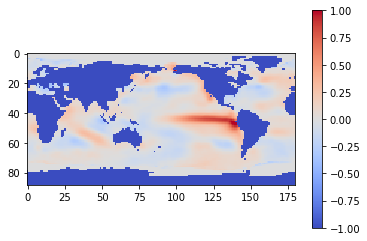

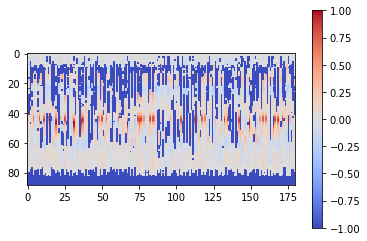

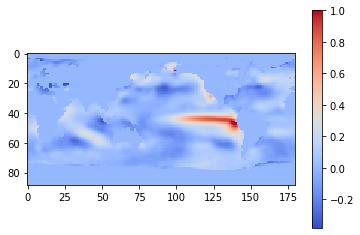

In [84]:
### Pick out ONE sample to be analysed:

# Set sample id:
sample_id = 40 # number 40 of validation inputs --> El Nino sample
#sample_id = 52 # number 52 of validation inputs --> La Nina sample

# Get original and permuted sample:
sample = val_input_swap[sample_id,:,:]
sample_perm = val_input_swap_perm[sample_id,:,:]
sample_perm_rev = val_input_swap_perm_rev[sample_id,:,:]

# Set former NaN values from zero to -1, to have better contrast for continents :
sample[sample==0] = -1
sample_perm[sample_perm==0] = -1

# Plot original sample:
plt.imshow(np.swapaxes(sample, 0,1), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

# Plot permutation:
plt.imshow(np.swapaxes(sample_perm, 0,1), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

# Plot sample after reversed permutation:
plt.imshow(np.swapaxes(sample_perm_rev, 0,1), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

### Train baseESN model (col-wise) on permuted inputs

In [72]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap_perm.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.005 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap_perm.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 1 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events on one-hot targets.

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 89)]         0         
_________________________________________________________________
esn_4 (ESN)                  ((None, 180, 300), (None, 117300    
_________________________________________________________________
output (Dense)               (None, 1)                 301       
Total params: 117,601
Trainable params: 117,601
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 89)]         0         
_________________________________________________________________
esn_4 (ESN)                  ((None, 180, 300), (None, 117300    
Total params: 117,300
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 180, 89)
shape of model output X_T (samples, n_res):  (831, 300)

Final reservoir states in augmented notation, shape:  (831, 301)

train_target shape (samples, output features):  (831, 1)

W_out shape:  (300, 1)
b_out shape:  (1,)

output feature  0 , trained b_out:  [29.26533175]


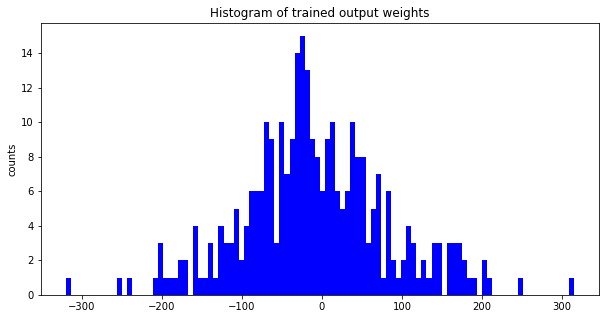


shape of val input (samples, timesteps, features):  (208, 180, 89)
shape of train input (samples, timesteps, features):  (831, 180, 89)

shape of model predictions on validation input (samples, 1):  (208, 1)
shape of val targets (samples, 1):  (208, 1)

train_mae:  0.0961
val_mae:  0.2979

train_mse:  0.0145
val_mse:  0.1397


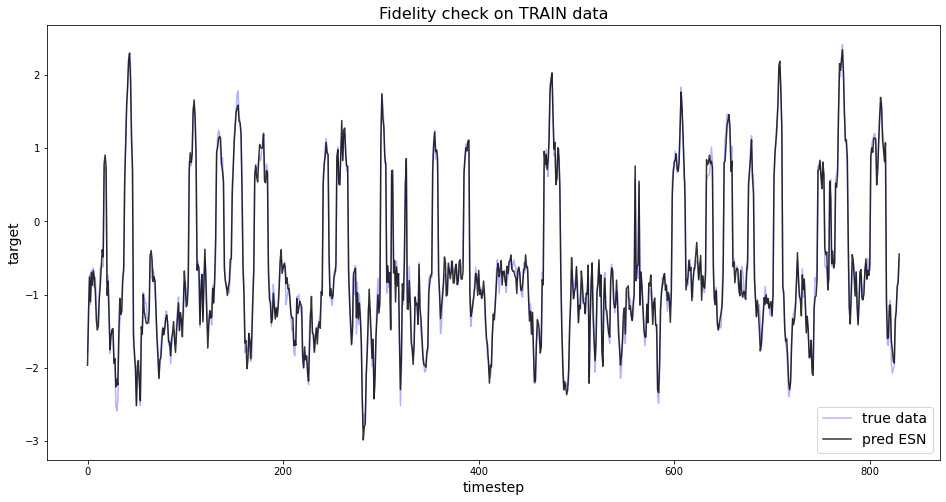

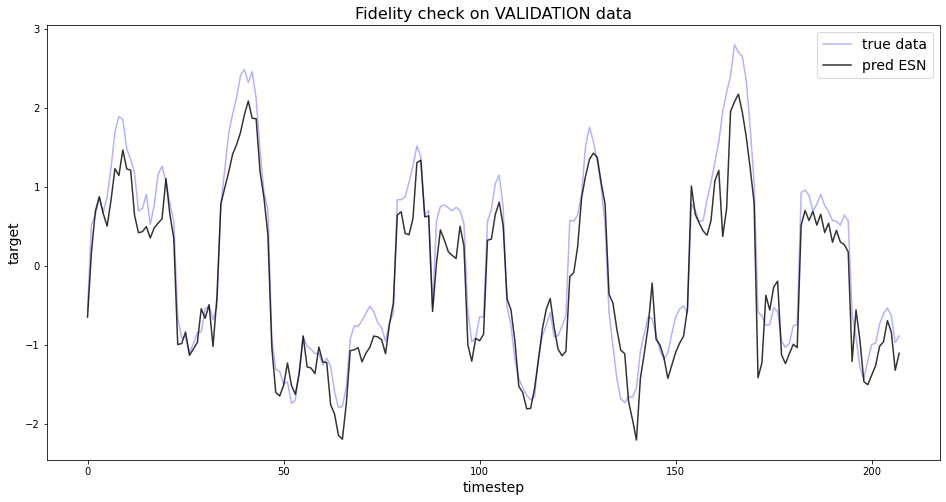

In [77]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_swap_perm, train_target, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_swap_perm,
                                                                       val_input_swap_perm,
                                                                       train_target, val_target,
                                                                       verbose=verbose)




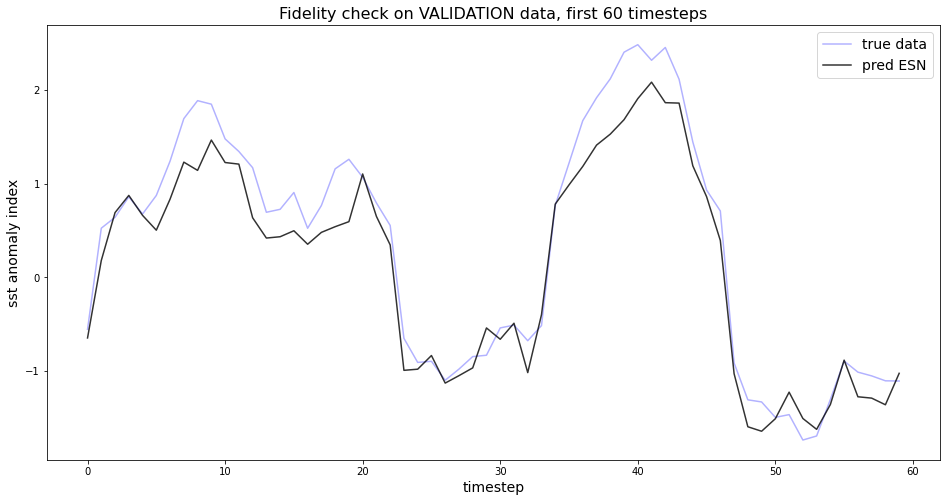

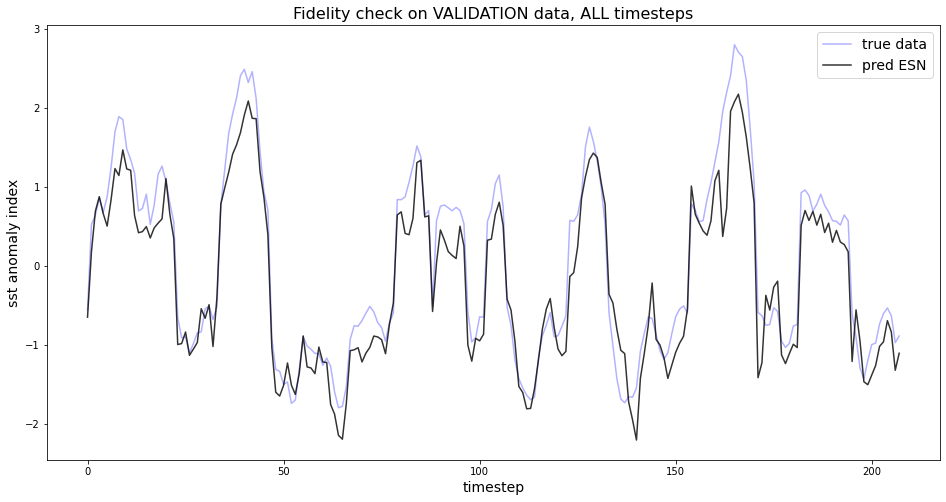

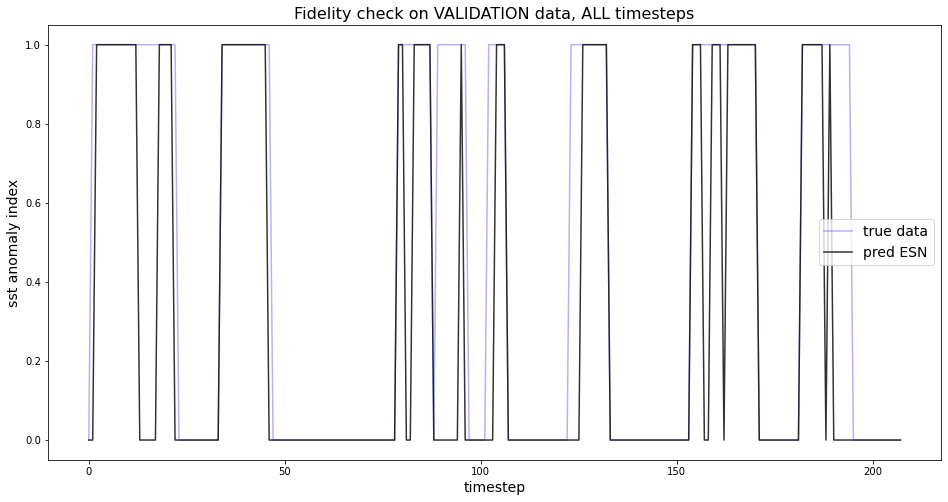


Validation accuracy:
El Nino:  0.68
La Nina:  1.0

Train accuracy:
El Nino:  0.94
La Nina:  1.0


In [78]:
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5)
val_pred_bin = (val_pred > 0.5)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target[:60,0])),val_target[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, ALL timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target[:,0])),val_target[:,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:,0])),val_pred[:,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('Fidelity check on VALIDATION data, ALL timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred_bin vs. val_targetbin, ALL timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_bin[:,0])),val_target_bin[:,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:,0])),val_pred_bin[:,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('Fidelity check on VALIDATION data, ALL timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()    


## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_bin[:,0]) & (val_target_bin[:,0] == 1)) / sum(val_target_bin[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,0] == val_target_bin[:,0]) & (val_target_bin[:,0] == 0)) / sum(val_target_bin[:,0] == 0)

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_bin[:,0]) & (train_target_bin[:,0] == 1)) / sum(train_target_bin[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,0] == train_target_bin[:,0]) & (train_target_bin[:,0] == 0)) / sum(train_target_bin[:,0] == 0)


if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 180, 89)
number of timesteps:  180
number of input features in_feat:  89
number of res. units n_res:  300
leak rate alpha:  0.005
model prediction on sample:  2.002

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (89, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 1)
output biases b_out (output features):  (1,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1224/2523413796.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Tensor shapes:
input tensor U (timesteps, input features):  (180, 89)
all res. states X (timesteps, res. units):  (180, 300)
activations ACT (timesteps, res. units):  (180, 300)


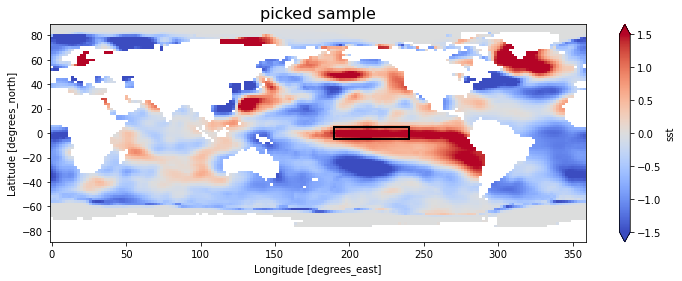

In [60]:
### Pick out ONE El Nino sample to be analysed:
sample_id = 40 # number 40 of validation inputs --> El Nino sample
#sample_id = 52 # number 52 of validation inputs --> La Nina sample
sample = val_input_swap_perm[sample_id:sample_id+1,:,:]

## If feeding the sample column-wise is desired, need to swap lat <-> lon for input sample:
#sample = np.swapaxes(sample, 1, 2)

# Plot sample input
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample: ", np.round(pred[0,0],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

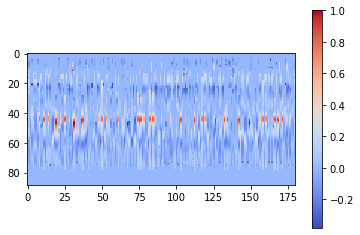

In [61]:
# Plot sample in reduced size:
plt.imshow(np.swapaxes(sample[0,:,:], 0,1), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [62]:
### LRP on baseESN (col-wise): Only take positive contributions of pre-potential into account.
### EL NINO

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_1pos = np.swapaxes(R_all, 0, 1)

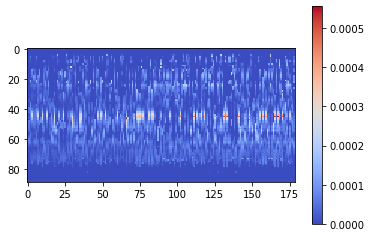

In [63]:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.005, random permutation on inputs
# Relevance heatmap for single El Nino sample, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [64]:
R_all_1pos.shape

(89, 179)

In [67]:
# Since we haven't finished LRP back to the first timestep, we are missing the first column in the
# obtained relevance map. Quick'n'dirty solution: Add first column as zeros, to have dimensions right:
R_all_1pos_ext = np.concatenate([np.zeros((89,1)), R_all_1pos], axis=1)

In [70]:
## Now reverse permutation to restore relevance map in its un-permuted form:

# Initialize storage (timesteps, features):
R_all_1pos_rev = np.zeros(R_all_1pos_ext.shape)

# Get reverse permutation from argsort:
perm_rev = np.argsort(rand_perm)
  
# Loop over number of features:
for feat in range(R_all_1pos_ext.shape[0]):

    # Store permutation:
    R_all_1pos_rev[feat,:] = R_all_1pos_ext[feat, perm_rev]

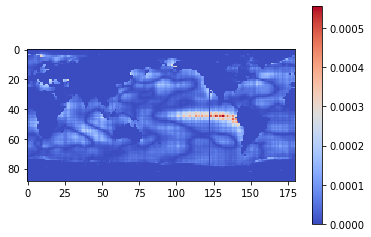

In [71]:
# baseESN, feed inputs col-wise, tanh activation, alpha = 0.005
# Relevance heatmap for single El Nino sample, CAPPED inputs (cap_limits = [-5, 5]), scaled to [-1,1]
# Single continuous normalized sst anomaly index as target.
plt.imshow(R_all_1pos_rev, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()